# Investigating Copy Number Variation Across KD Populations
 
1. Run through the 10x Cellranger pipeline and velocyto for single cell RNAseq quatification and using (2) guides quantifiction. all found in the cellranger files folder **bash**
2.  Guide Calling for dual guide. Use repogle method to take molecule.h5 generated by cellranger and py to run through repogle version of guide calling or use cellranger_guidecalling.ipynb for Direct Capture Perturb-Seq dual guide. Formed guide-specific lists of cells.
3. Pseudobulk analysis.
    A. Seperation of guide-specific fastq files. **bash**
    B. Whippet pseudobulk for transcript specific analysis, post UMI deduplication.  **bash**
    C. Transcript quality control. **R**
    D. Whippet result visualisation.
4. Normalisation of adata object and E-distance of KD
5. Check gene and neighboring gene expression
6. Create individual umaps per gene of interest
    A. UMAPs 
    B. Rand Index score
7. Cell phase assignment model from FUCCI-matched single cell paper (GSE146773)
8. Differential Expression analysis.
    A. Find the shared P1 and P2 genes. 
    B. Check the shared P1 and P2 across different protospacers with the same A/B and C/D.
9.  **CNV Score & Numbat to quantify and Velocity quantification with loom file**
10. ESR1-specific analysis from proliferation analysis to rt-qpcr
11.  Spectra analysis and visualisation for pathway enrichment

This script is dedicated to the chromosomal analysis part of the study. Specifically, it uses single-cell RNA sequencing (scRNA-seq) data to infer Copy Number Variations (CNVs)—large-scale chromosomal gains or losses—to understand how different promoter knockdowns impact genomic stability in breast cancer cells.


Inferring Chromosomal Changes from Gene Expression
Since the study uses scRNA-seq rather than DNA sequencing, it employs a tool called inferCNV to estimate chromosomal changes.



What is happening: The code computes a rolling average of gene expression across genomic windows (typically 100 genes).



The Logic: If a large block of adjacent genes shows consistently higher or lower expression compared to a reference set, the model infers a chromosomal gain or loss in that region




In [ ]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

import sys
sys.path.append(loc)
from infercnvpy_test import *

#general
import scanpy as sc
import matplotlib.pyplot as pl
import anndata as ad
import pandas as pd
import numpy as np
import hdf5plugin

#form a location
loc="alt-prom-crispr-fiveprime/"

import seaborn as sns
from tqdm.notebook import tqdm
import scperturb
import sys
sys.path.append(loc+'scripts/')
from apu_analysis import *
import scperturb
import infercnvpy as cnv
from apu_analysis.cell_import import CellPopulation
from IPython.display import clear_output
pd.options.display.float_format = '{:.4f}'.format
import matplotlib.pyplot as plt
import scvelo as scv
from matplotlib_venn import venn3

#for this python
from scipy.special import rel_entr
import sklearn.cluster as cluster
import umap
from scipy import stats
from scipy.stats import bootstrap
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
from numpy import reshape
from numpy import array
from sklearn.decomposition import PCA


# Taken from: 
# Adamson, B.A., Norman, T.M., *et al.* "A multiplexed CRISPR screening platform enables systematic dissection of the unfolded protein response", *Cell*, 2016.
# My experiment deals with two KDs- one of the MP, one of the AP using two guides. Positve controls include GINS1 ect. This is a combnatorial KD double for the same gene. No treatments were used

# colours using garvan 
color1 ='#4d00c7'
palecolor1="#b366ff"
color2= '#da3c07'
palecolor2="#ff8954"
color3='#05d3d3'
color4='#c6c7c5'
color4="#434541"
color5="#eb31e1"
color6="#3175eb"
color7="#a7eb31"
color8="#b366ff"
color9="#ff8954"
color10="#35c9d4"

#use viridis
color1="#fde725"
color2="#7ad151"
color3="#22a884"
color4="#2a788e"
color5="#2a788e"
color6='#440154'
# %%capture


# Create the color palette
palette = sns.color_palette([palecolor1,palecolor2])
palette2 = sns.color_palette([color1, color2, color3, color4,color5,color6 ,color7])

# Create the color palette
palette = sns.color_palette([color1, color2,color3])
new_palette = sns.color_palette([color1, color2,color1, color2,color1, color2,color1, color2,color1, color2,color1, color2, color3, color4])



print("Scanpy", sc.__version__)
%matplotlib inline

In [ ]:
adata = ad.read_h5ad(loc+"files/adata_normalised.h5ad")
#set the log1p
# adata.X = adata.layers["raw"]
adata.X = adata.layers["counts"]

In [4]:
 #import and process the protein list 
gene_list = pd.read_csv(loc+'files/reference/cellranger-GRCh38-1.2.0_only_genes.gtf',
            sep='\t',
            header=None,
            names=['chr', 'source', 'type', 'start', 'end', 'null1', 'orientation', 'null2', 'notes'])

gene_list = gene_list[['chr', 'source', 'type', 'start', 'end', 'orientation', 'notes']]
gene_list['gene_id'] = gene_list['notes'].map(lambda x: x.split('"')[1])

gene_list["notes"][0]

gene_list['gene_name'] = gene_list['notes'].map(lambda x: x.split('"')[7])
gene_list['gene_type'] = gene_list['notes'].map(lambda x: x.split('"')[5])

protein_gene_list = gene_list[gene_list['gene_type'] == "protein_coding"]
protein_gene_list = protein_gene_list[protein_gene_list["gene_name"].isin(list(adata.var_names))] ##subseet for the genes found in the signle cell matrix 
protein_gene_list=protein_gene_list.groupby("gene_name").head(n=1)
protein_gene_list.reset_index(inplace=True,drop=True)
##add annotations for snv 
#subset adata to only include the genes that are in the protein_gene_list
adata_ens=adata[:,adata.var.index.isin(protein_gene_list["gene_name"])]
adata_ens.var["ensg"]=pd.Categorical(protein_gene_list["gene_id"][protein_gene_list["gene_name"].isin(adata_ens.var.index)])
adata_ens.var["chromosome"]=pd.Categorical(protein_gene_list["chr"][protein_gene_list["gene_name"].isin(adata_ens.var.index)])
adata_ens.var["start"]=pd.Categorical(protein_gene_list["start"][protein_gene_list["gene_name"].isin(adata_ens.var.index)])
adata_ens.var["end"]=pd.Categorical(protein_gene_list["end"][protein_gene_list["gene_name"].isin(adata_ens.var.index)])


In [5]:
# Define file path
file_path = loc + 'files/reference/cellranger-GRCh38-1.2.0_only_genes.gtf'

# Import and process the protein list 
gene_list = pd.read_csv(file_path, sep='\t', header=None, 
                        names=['chr', 'source', 'type', 'start', 'end', 'null1', 'orientation', 'null2', 'notes'])

# Select necessary columns
gene_list = gene_list[['chr', 'source', 'type', 'start', 'end', 'orientation', 'notes']]

# Extract gene_id, gene_name, and gene_type from 'notes' column
gene_list['gene_id'] = gene_list['notes'].apply(lambda x: x.split('"')[1])
gene_list['gene_name'] = gene_list['notes'].apply(lambda x: x.split('"')[7])
gene_list['gene_type'] = gene_list['notes'].apply(lambda x: x.split('"')[5])

# Filter for protein coding genes
protein_gene_list = gene_list[gene_list['gene_type'] == "protein_coding"]

# Subset for the genes found in the single cell matrix 
protein_gene_list = protein_gene_list[protein_gene_list["gene_name"].isin(list(adata.var_names))]

# Group by gene_name and keep first entry
protein_gene_list = protein_gene_list.groupby("gene_name").first().reset_index()

# Subset adata to only include the genes that are in the protein_gene_list
adata_ens = adata[:, ((adata.var.index.isin(protein_gene_list["gene_name"])&(adata.var['mt']==False)))]
# adata_ens = adata



In [6]:
adata_ens.var=adata_ens.var.merge(protein_gene_list,right_on="gene_name",left_index=True).set_index('gene_name')
#change column names from in dictionary_columns
dictionary_columns={"ensg":"gene_id","chr":"chromosome","start":"start","end":"end"} 
adata_ens.var.rename(columns=dictionary_columns,inplace=True)

... storing 'chromosome' as categorical
... storing 'source' as categorical
... storing 'type' as categorical
... storing 'orientation' as categorical
... storing 'gene_type' as categorical


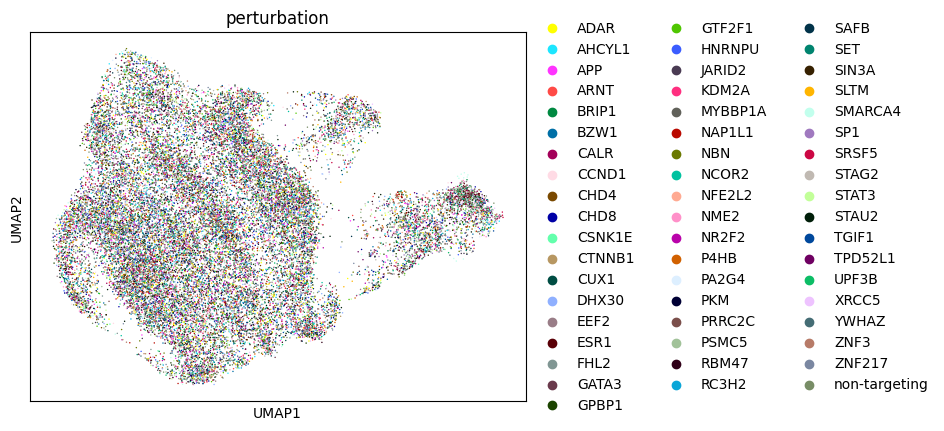

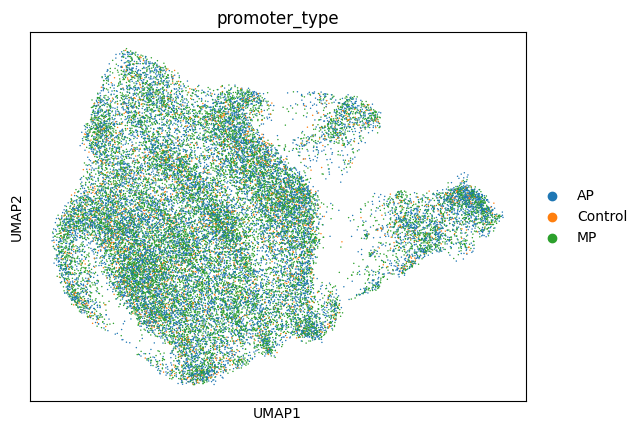

In [7]:
sc.tl.umap(adata_ens)
###iterate through and create correlation matrix
sc.pl.umap(adata_ens, color="perturbation")
sc.pl.umap(adata_ens, color="promoter_type")

In [8]:
#check that the gtf contains genes that were contained 
gencode_peaks_gtf_esr1=loc+"files/reference/remap2022_ESR1_nr_macs2_hg38_v1_0.mcf7.gencode.gtf"
#subset select for genes of interest 
gencode_peaks_gtf_esr1=pd.read_csv(gencode_peaks_gtf_esr1, sep="\t",header=None)
#check that the gtf contains genes that were contained 
gencode_peaks_gtf_ar=loc+"files/reference/GSE48930.AR.MCF-7.gencode.gtf"
#subset select for genes of interest 
gencode_peaks_gtf_ar=pd.read_csv(gencode_peaks_gtf_ar, sep="\t",header=None)

In [9]:
#get list of genes that arre in adata_ens
adata_gene_names=adata_ens.var_names
#get the names of androgen 
esr1_targeted_gene_names=gencode_peaks_gtf_esr1[3].drop_duplicates()
#interection of the two lists
esr1_adata_targeted_genelist=list(set(adata_gene_names).intersection(esr1_targeted_gene_names))
print(len(esr1_adata_targeted_genelist))
esr1_adata=adata_ens[:,adata_ens.var_names.isin(esr1_adata_targeted_genelist)]
#match the genes selected for new_not to be similarly expressed
min_esr1_value=esr1_adata.var.means.min()
#subset the genes that have the mean expression value greater than the min_esr1_value and not included in esr1_adata_targeted_genelist
esr1_not_in_gene_names=adata_ens.var_names[(adata_ens.var.means>min_esr1_value) & (~adata_ens.var_names.isin(esr1_adata_targeted_genelist))]
print(len(esr1_not_in_gene_names))

#input esr1_adata_min 
esr1_adata_notin=adata_ens[:,adata_ens.var_names.isin(esr1_not_in_gene_names)]

144
11081


In [10]:
#form two dataframes ar_adata and ar_adata_notin
ar_targeted_gene_names=gencode_peaks_gtf_ar[3].drop_duplicates()
#interection of the two lists
ar_adata_targeted_genelist=list(set(adata_gene_names).intersection(ar_targeted_gene_names))
#remove all genes that are in er_targeted_gene_names
ar_adata_targeted_genelist=list(set(ar_adata_targeted_genelist)-set(esr1_adata_targeted_genelist))
print(len(ar_adata_targeted_genelist))
ar_adata=adata_ens[:,adata_ens.var_names.isin(ar_adata_targeted_genelist)]

#match the genes selected for new_not to be similarly expressed
min_ar_value=ar_adata.var.means.min()
#subset the genes that have the mean expression value greater than the min_esr1_value and not included in esr1_adata_targeted_genelist
ar_not_in_gene_names=adata_ens.var_names[(adata_ens.var.means>min_ar_value) & (~adata_ens.var_names.isin(ar_adata_targeted_genelist))]
print(len(ar_not_in_gene_names))

#input esr1_adata_min 
ar_adata_notin=adata_ens[:,adata_ens.var_names.isin(ar_not_in_gene_names)]

52
10917


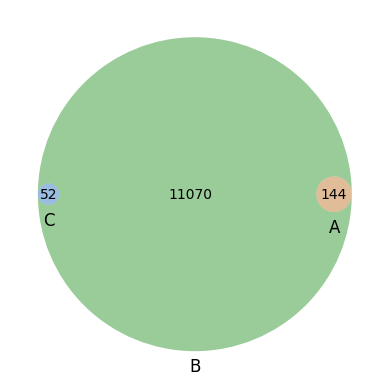

In [13]:
#only the 
venn3([set(esr1_adata_targeted_genelist), set(adata_gene_names),set(ar_adata_targeted_genelist) ], ('ESR1', 'All Genes', 'AR'))
plt.show()

In [14]:
#need to repeat the calculation 6 times 
#once for esr1 only 
esr1_not_int=esr1_adata_notin[(esr1_adata_notin.obs["promoter_type"] == "Control") | (esr1_adata_notin.obs["perturbation"] == "ESR1")] 
esr1=esr1_adata[(esr1_adata.obs["promoter_type"] == "Control") | (esr1_adata.obs["perturbation"] == "ESR1")] 
ar_not_in=ar_adata_notin[(ar_adata_notin.obs["promoter_type"] == "Control") | (ar_adata_notin.obs["perturbation"] == "ESR1")]
ar=ar_adata[(ar_adata.obs["promoter_type"] == "Control") | (ar_adata.obs["perturbation"] == "ESR1")]
esr1_full=adata_ens[(adata_ens.obs["promoter_type"] == "Control") | (adata_ens.obs["perturbation"] == "ESR1")] 


In [19]:
esr1_full=esr1_full[:,~esr1_full.var["chromosome"].isin(["chrX","chrY"])]

# #window size is the size of the running window (so the number of genes to iunclude)
# #step means the computong the number of window 
chr_pos, res, df,full_gene_df = tl.infercnv(
esr1_full,
reference_key="guide_id",
reference_cat="non-targeting_Control",
window_size=1,
inplace=False,
step=1,
calculate_gene_values=True
)
#merge test with  esr1_full.obs
full_gene_df=pd.merge(esr1_full.obs[["guide_id","guide_assignment","perturbation"]],full_gene_df,left_index=True,right_index=True)
full_gene_df_mean=full_gene_df.drop(["guide_assignment","perturbation"],axis=1).groupby(["guide_id"]).agg({'mean'}).transpose().sort_values(by="ESR1_AP",ascending=False)
#add the gene info from the adata_ens.var
full_gene_df_mean=full_gene_df_mean.reset_index()
# full_gene_df_mean
full_gene_df_mean.columns=[ "gene_id","metric", "ESR1_AP","ESR1_MP","non-targeting_Control"]
full_gene_df_mean=full_gene_df_mean.merge(adata_ens.var[["chromosome","start","end","gene_id","orientation","notes"]],left_on="gene_id",right_index=True).drop("gene_id_x",axis=1).rename(columns={"gene_id_y":"ensembl_id"})
full_gene_df_mean.to_csv(loc+"files/cnv_mean_score_esr1.csv")

100%|██████████| 1/1 [01:30<00:00, 90.50s/it]


check


In [23]:
#input df 
cnv_score_list=[]
c=0
df_list=[esr1_not_int,esr1,ar_not_in,ar,esr1_full]
elements_list=["F","T","F","T","None"]
binding_regions_list=["esr1","esr1","ar","ar","non_targeting"]
for c in range(0,5):
    df=df_list[c]
    cnv.tl.infercnv(
        df,
        reference_key="guide_id",
        reference_cat="non-targeting_Control",
        window_size=1,
        step=1,
    )
    cnv.pp.neighbors(df)
    cnv.tl.leiden(df)
    #check the input df name is esr1
    cnv.tl.cnv_score(df)
    cnv_score=pd.DataFrame(df.obs[["cnv_score","perturbation","promoter_type"]])
    cnv_score["elements"]=elements_list[c]
    cnv_score["binding_regions"]=binding_regions_list[c]
    #add the dataframe esr1 cnv_score_list
    cnv_score_list.append(cnv_score)
    #plot binding regions esr1 and elements list T 



#concatenate the dataframes
cnv_score_df=pd.concat(cnv_score_list)
#need to make a graph which shows x-axis the cnv score and y-axis score 
#export cnv_score to csv

cnv_score_df.to_csv(loc+"files/singlecell_shortread_analysis/cnv_score.csv")


100%|██████████| 1/1 [00:03<00:00,  3.87s/it]


  File "/Users/helenking/anaconda3/envs/apu/lib/python3.12/site-packages/joblib/externals/loky/backend/context.py", line 270, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "/Users/helenking/anaconda3/envs/apu/lib/python3.12/subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/helenking/anaconda3/envs/apu/lib/python3.12/subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "/Users/helenking/anaconda3/envs/apu/lib/python3.12/subprocess.py", line 1955, in _execute_child
    raise child_exception_type(errno_num, err_msg, err_filename)
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
100%|██████████| 1/1 [00:01<00:00,  1.94s/it]


100%|██████████| 1/1 [00:03<00:00,  3.37s/it]


100%|██████████| 1/1 [00:01<00:00,  1.63s/it]


100%|██████████| 1/1 [00:03<00:00,  3.36s/it]


In [25]:
#for every perturbation of interest 
adata_gene=adata_ens.obs["perturbation"].unique()
#only extract perturbations which contain P1 or P2
cnv_score_list_total=[]
for gene_pos in range(0,len(adata_gene)):
# for gene_pos in range(0,2):
    gene=adata_gene[gene_pos]
    print(gene)
    if gene in ["non-targeting"]:
        continue
    #subset the adata to only include the gene of interest
    df=adata_ens[(adata_ens.obs["perturbation"]==gene)|(adata_ens.obs["perturbation"]=="non-targeting")]
    print(df.shape)
    cnv.tl.infercnv(
        df,
        reference_key="guide_id",
        reference_cat="non-targeting_Control",
        window_size=1,
        step=1,

    )
    cnv.pp.neighbors(df)
    cnv.tl.leiden(df)
    cnv.tl.cnv_score(df)
    cnv_score=pd.DataFrame(df.obs[["cnv_score","perturbation","promoter_type"]])
    #add the dataframe esr1 cnv_score_list
    cnv_score_list_total.append(cnv_score)

NBN
(2812, 11266)


100%|██████████| 1/1 [00:03<00:00,  3.86s/it]


PA2G4
(2738, 11266)


100%|██████████| 1/1 [00:03<00:00,  3.76s/it]


PKM
(2763, 11266)


100%|██████████| 1/1 [00:03<00:00,  3.70s/it]


SIN3A
(3020, 11266)


100%|██████████| 1/1 [00:03<00:00,  3.91s/it]


non-targeting
SP1
(2885, 11266)


100%|██████████| 1/1 [00:04<00:00,  4.19s/it]


FHL2
(2808, 11266)


100%|██████████| 1/1 [00:04<00:00,  4.07s/it]


AHCYL1
(2753, 11266)


100%|██████████| 1/1 [00:03<00:00,  3.84s/it]


CHD4
(2745, 11266)


100%|██████████| 1/1 [00:03<00:00,  3.89s/it]


CUX1
(2773, 11266)


100%|██████████| 1/1 [00:05<00:00,  5.35s/it]


XRCC5
(2759, 11266)


100%|██████████| 1/1 [00:03<00:00,  3.97s/it]


PRRC2C
(2731, 11266)


100%|██████████| 1/1 [00:05<00:00,  5.29s/it]


CALR
(2847, 11266)


100%|██████████| 1/1 [00:04<00:00,  4.23s/it]


GATA3
(2670, 11266)


100%|██████████| 1/1 [00:04<00:00,  4.11s/it]


ESR1
(2691, 11266)


100%|██████████| 1/1 [00:03<00:00,  3.95s/it]


CHD8
(2778, 11266)


100%|██████████| 1/1 [00:04<00:00,  4.35s/it]


SMARCA4
(2980, 11266)


100%|██████████| 1/1 [00:04<00:00,  4.70s/it]


APP
(2700, 11266)


100%|██████████| 1/1 [00:04<00:00,  4.47s/it]


JARID2
(2695, 11266)


100%|██████████| 1/1 [00:04<00:00,  4.73s/it]


KDM2A
(2664, 11266)


100%|██████████| 1/1 [00:04<00:00,  4.17s/it]


MYBBP1A
(2784, 11266)


100%|██████████| 1/1 [00:04<00:00,  4.58s/it]


STAT3
(2946, 11266)


100%|██████████| 1/1 [00:04<00:00,  4.35s/it]


NAP1L1
(2735, 11266)


100%|██████████| 1/1 [00:03<00:00,  3.74s/it]


SRSF5
(2749, 11266)


100%|██████████| 1/1 [00:03<00:00,  3.84s/it]


STAG2
(2811, 11266)


100%|██████████| 1/1 [00:03<00:00,  3.78s/it]


SAFB
(2709, 11266)


100%|██████████| 1/1 [00:03<00:00,  3.72s/it]


SET
(2899, 11266)


100%|██████████| 1/1 [00:03<00:00,  3.81s/it]


HNRNPU
(2724, 11266)


100%|██████████| 1/1 [00:03<00:00,  3.69s/it]


NME2
(2769, 11266)


100%|██████████| 1/1 [00:03<00:00,  3.96s/it]


ZNF217
(2790, 11266)


100%|██████████| 1/1 [00:03<00:00,  3.70s/it]


NCOR2
(2776, 11266)


100%|██████████| 1/1 [00:03<00:00,  3.67s/it]


TGIF1
(2805, 11266)


100%|██████████| 1/1 [00:03<00:00,  3.82s/it]


DHX30
(2793, 11266)


100%|██████████| 1/1 [00:03<00:00,  3.84s/it]


BRIP1
(2775, 11266)


100%|██████████| 1/1 [00:03<00:00,  3.75s/it]


GPBP1
(2811, 11266)


100%|██████████| 1/1 [00:03<00:00,  3.81s/it]


NR2F2
(2726, 11266)


100%|██████████| 1/1 [00:03<00:00,  3.72s/it]


YWHAZ
(2936, 11266)


100%|██████████| 1/1 [00:03<00:00,  3.75s/it]


STAU2
(2812, 11266)


100%|██████████| 1/1 [00:03<00:00,  3.74s/it]


ADAR
(2892, 11266)


100%|██████████| 1/1 [00:03<00:00,  3.77s/it]


BZW1
(2859, 11266)


100%|██████████| 1/1 [00:03<00:00,  3.87s/it]


ARNT
(2553, 11266)


100%|██████████| 1/1 [00:03<00:00,  3.66s/it]


CTNNB1
(2833, 11266)


100%|██████████| 1/1 [00:03<00:00,  3.78s/it]


CCND1
(2655, 11266)


100%|██████████| 1/1 [00:03<00:00,  3.78s/it]


GTF2F1
(2657, 11266)


100%|██████████| 1/1 [00:03<00:00,  3.82s/it]


CSNK1E
(2478, 11266)


100%|██████████| 1/1 [00:03<00:00,  3.98s/it]


ZNF3
(2709, 11266)


100%|██████████| 1/1 [00:04<00:00,  4.54s/it]


TPD52L1
(2754, 11266)


100%|██████████| 1/1 [00:04<00:00,  4.04s/it]


PSMC5
(2828, 11266)


100%|██████████| 1/1 [00:04<00:00,  4.19s/it]


EEF2
(2780, 11266)


100%|██████████| 1/1 [00:04<00:00,  4.15s/it]


NFE2L2
(2658, 11266)


100%|██████████| 1/1 [00:03<00:00,  3.78s/it]


SLTM
(2725, 11266)


100%|██████████| 1/1 [00:04<00:00,  4.05s/it]


UPF3B
(2618, 11266)


100%|██████████| 1/1 [00:04<00:00,  4.21s/it]


RBM47
(2672, 11266)


100%|██████████| 1/1 [00:04<00:00,  4.51s/it]


RC3H2
(2707, 11266)


100%|██████████| 1/1 [00:04<00:00,  4.59s/it]


P4HB
(2759, 11266)


100%|██████████| 1/1 [00:05<00:00,  5.83s/it]


Identifying Promoter-Specific Genomic Instability
A major biological finding in the paper is that different promoters of the same gene can have vastly different effects on genomic integrity.


The ESR1 Discovery: The notebook compares CNV scores between the P1 and P2 knockdowns of the estrogen receptor gene (ESR1).

Result Found: Knocking down the P2 promoter of ESR1 led to a significant increase in CNVs among cell cycle-related genes compared to P1 and control populations ($p < 1.1 \times 10^{-7}$)77.

Statistical Validation of CNV Differences
To ensure these inferred changes are statistically robust, the notebook applies several tests:


Wilcoxon Rank Sum Test: Used to determine if the distribution of CNV scores in P2-knockdown cells is significantly higher than in P1 or NTC (Non-Targeting Control) cells.



Effect Size Calculation: The code calculates metrics like Cliff’s delta and Vargha and Delaney’s A to quantify the magnitude of the difference in genomic instability between the different promoter-targeted populations

100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


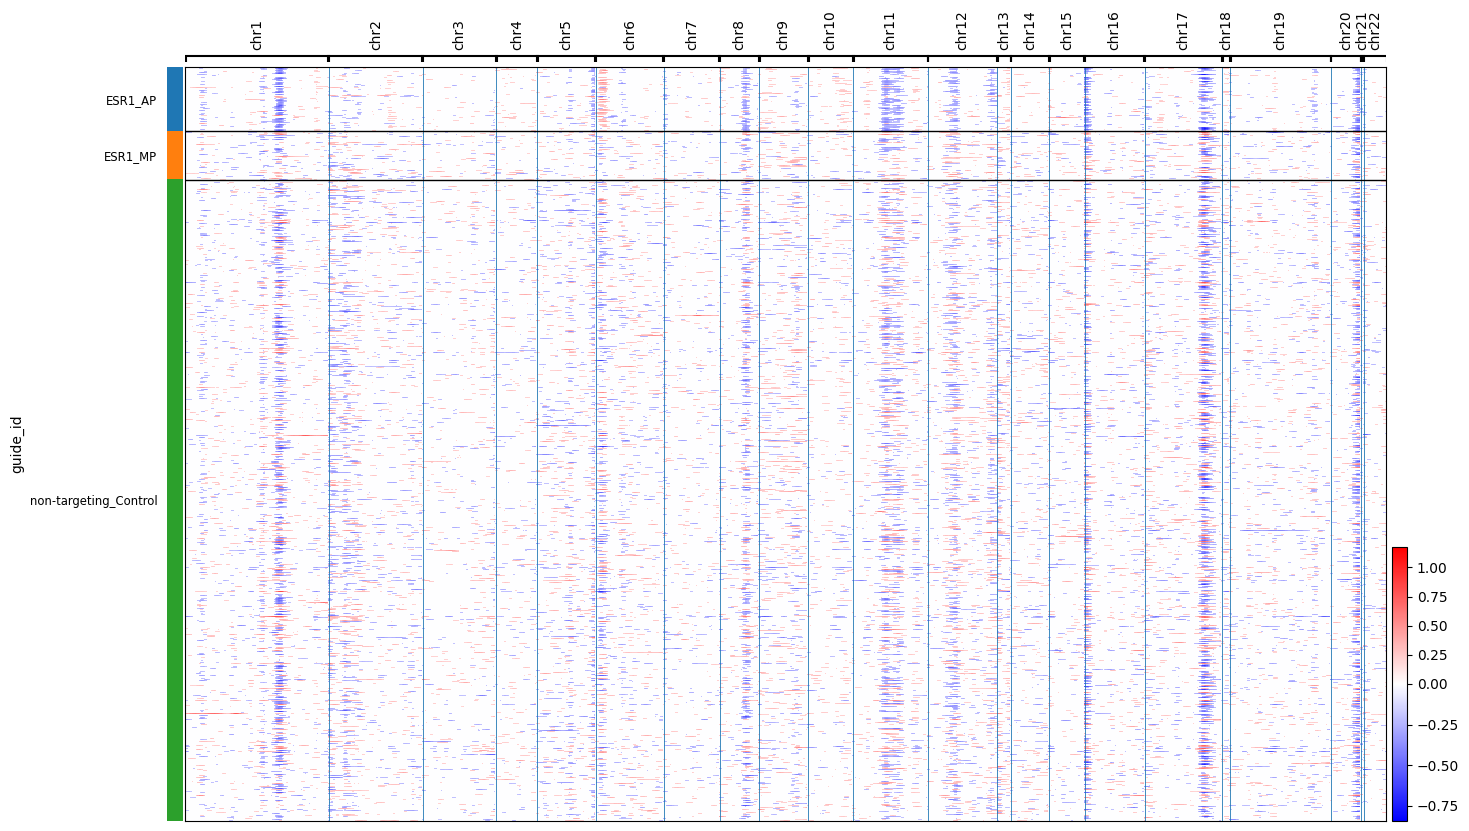

... storing 'guide_id' as categorical


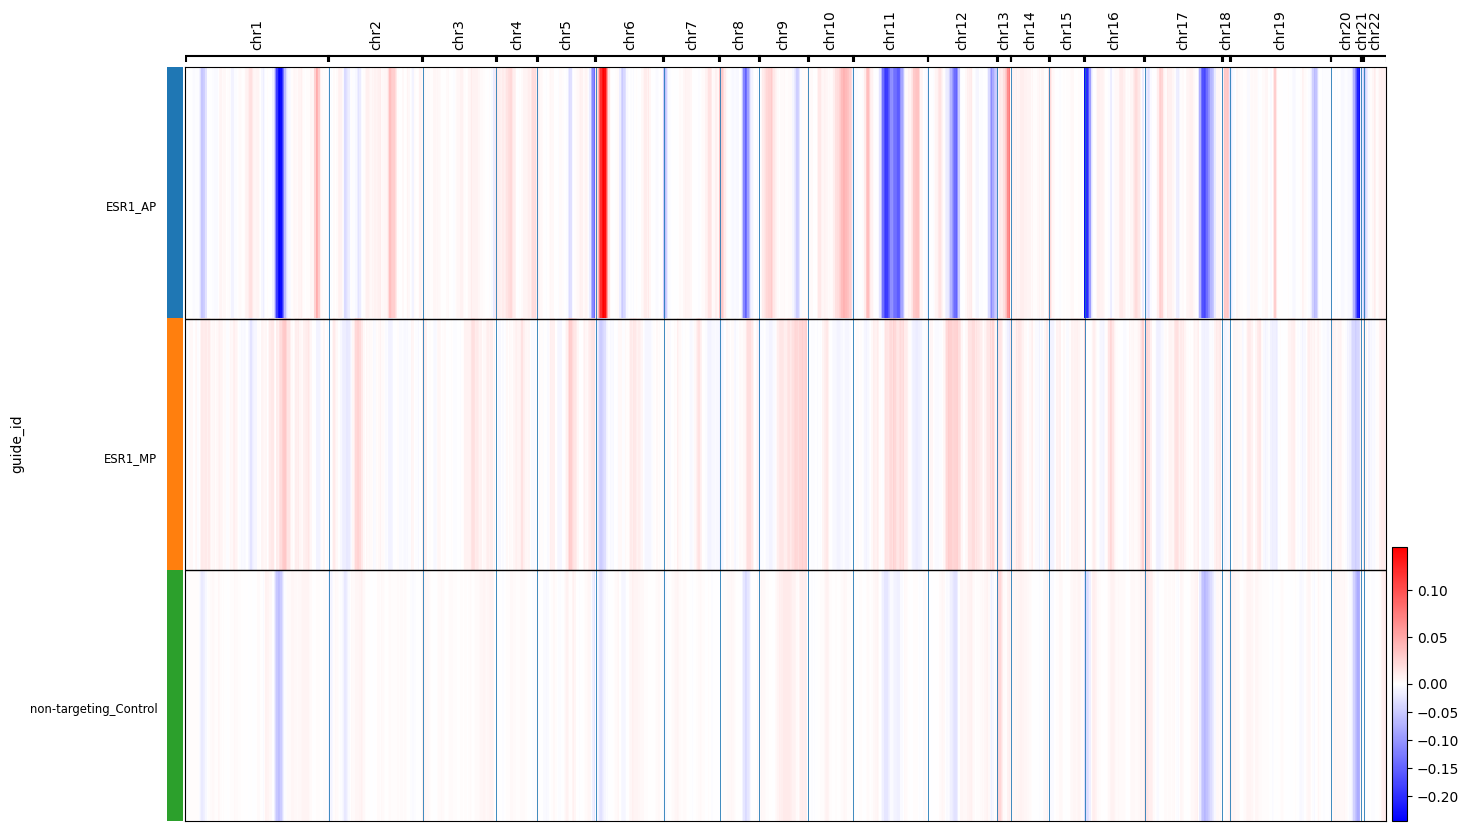

In [28]:
cnv.tl.infercnv(
    esr1_full,
    reference_key="guide_id",
    reference_cat="non-targeting_Control",

)
cnv.pp.neighbors(esr1_full)
cnv.tl.leiden(esr1_full)
cnv.tl.cnv_score(esr1_full)
cnv.pl.chromosome_heatmap(esr1_full, groupby="guide_id")
cnv.pl.chromosome_heatmap_summary(esr1_full, groupby="guide_id",save="esr1_full.pdf")


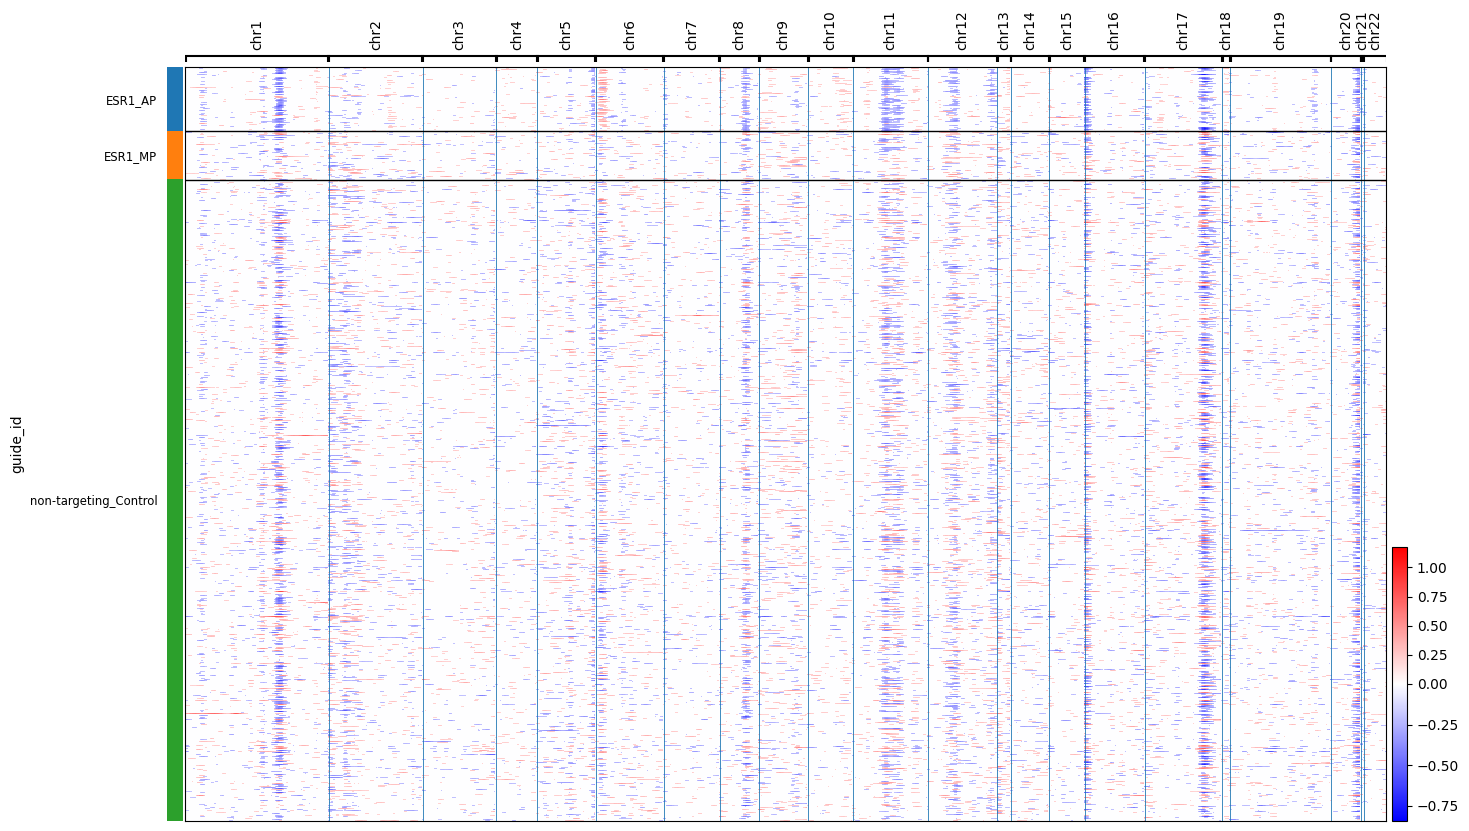

... storing 'guide_id' as categorical


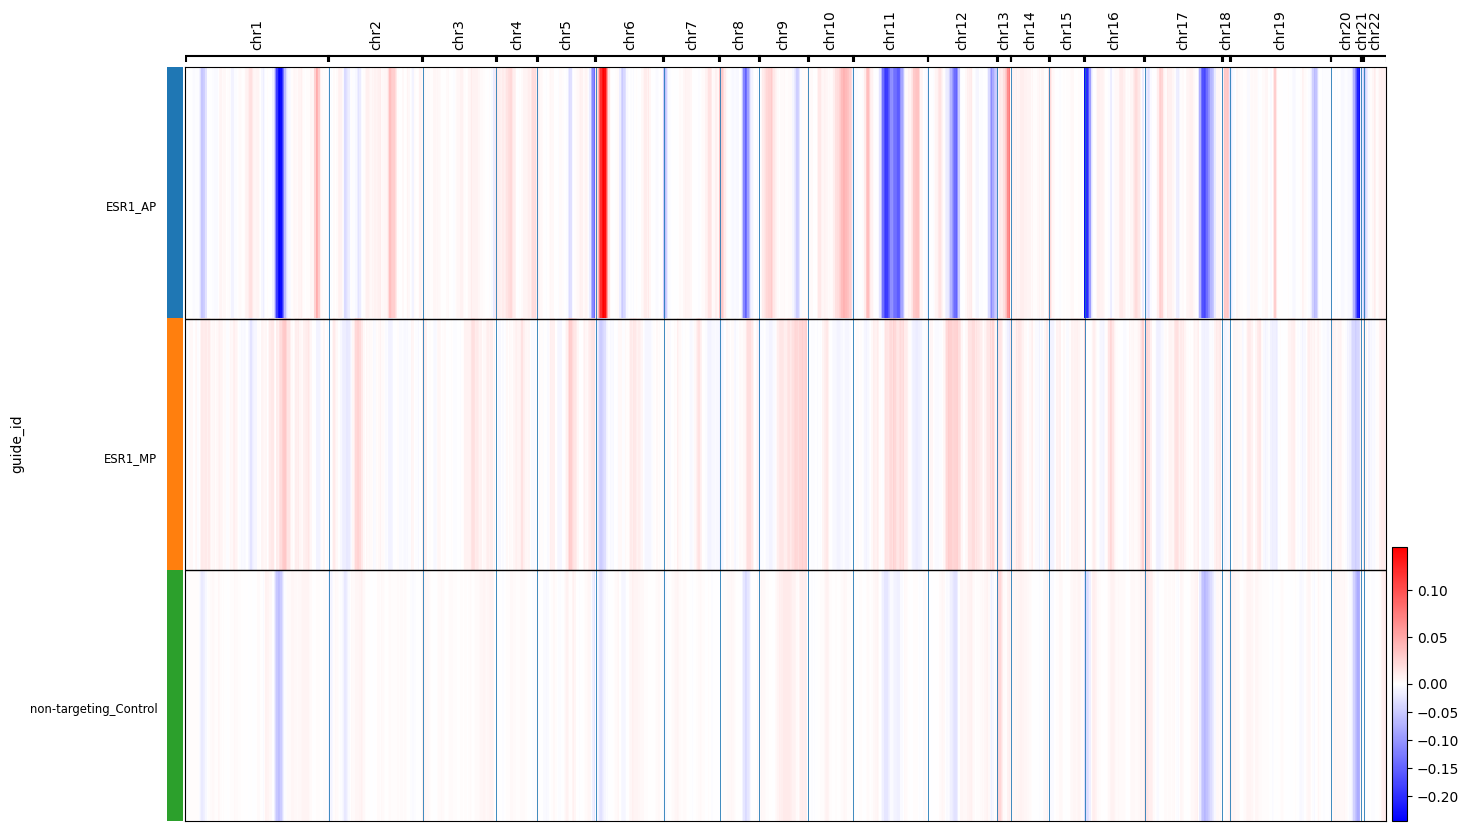

In [29]:
cnv.pl.chromosome_heatmap(esr1_full, groupby="guide_id")
cnv.pl.chromosome_heatmap_summary(esr1_full, groupby="guide_id",save="esr1_full.pdf")


In [31]:
#need to make a graph which shows x-axis the cnv score and y-axis score 
#export cnv_score to csv
cnv_score_df=pd.concat(cnv_score_list_total)

cnv_score_df.to_csv(loc+"files/singlecell_shortread_analysis/cnv_score_allgene.csv")